# 基于PyTorch框架的手写数字识别

## 构建LeNet5模型
按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。
![LeNet5的网络结构图](assets/lenet.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.conv1 = nn.Conv2d(self.in_channels, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1, )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 设置全局种子

In [4]:
import numpy as np
import random

seed = 777

def seed_everything(seed):
    if seed >= 10000:
        raise ValueError("seed number should be less than 10000")
    if torch.distributed.is_initialized():
        rank = torch.distributed.get_rank()
    else:
        rank = 0
    seed = (rank * 100000) + seed

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything(seed)

## 设置超参数

In [3]:
epochs = 30
learning_rate = 0.01
batch_size = 256
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 下载并处理数据集
MNIST数据集是由10类28∗28的灰度图片组成，训练数据集包含60000张图片，测试数据集包含10000张图片。
利用MindSpore Vision提供的的Mnist模块，将数据集下载、解压到指定位置并进行数据处理。

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                          transforms.ToTensor(), ])
transform_test = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.ToTensor(), ])
# 训练数据集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 测试数据集
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练数据集大小：", len(train_dataset))
print("测试数据集大小：", len(test_dataset))

训练数据集大小： 60000
测试数据集大小： 10000


## 创建模型

In [6]:
net = LeNet5()
print(net)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 定义损失函数和优化器
损失函数这里使用交叉熵损失函数CrossEntropy, 优化器这里使用SGD。

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

## 动态学习率
定义学习率调度器，每10个epoch降低学习率到原来的0.1倍  

In [8]:
from torch.optim.lr_scheduler import StepLR 

scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

## 训练及保存模型
训练过程中保存训练损失和正确率信息，以便后面进行分析。

In [9]:
from tqdm import tqdm

def train(model, epochs, optimizer, criterion, device, train_loader, lr_scheduler):
    train_losses = []
    train_acc = []
    model = model.to(device)
    model.train()
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        for batch_idx, (images, targets) in enumerate(tqdm(train_loader, 'train')):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)

            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        lr_scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(running_correct / total)

        torch.save(model.state_dict(), './lenet_pytorch/LeNet5_epoch_{:03}.pth'.format(i))

        print(f"Epoch {i+1}/{epochs}, Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Learning rate: {optimizer.state_dict()['param_groups'][0]['lr']:.5f}")

    return train_losses, train_acc

import os  
if not os.path.exists('letnet_pytorch'):   
    os.makedirs('letnet_pytorch')

train_losses, train_acc = train(net, epochs, optimizer, criterion, device, train_loader, scheduler)

train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:06<00:00, 38.97it/s]


Epoch 1/30, Train Loss: 1.116, Train Acc: 0.651, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:10<00:00, 22.38it/s]


Epoch 2/30, Train Loss: 0.169, Train Acc: 0.948, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:10<00:00, 21.52it/s]


Epoch 3/30, Train Loss: 0.105, Train Acc: 0.967, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:10<00:00, 23.42it/s]


Epoch 4/30, Train Loss: 0.077, Train Acc: 0.976, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.67it/s]


Epoch 5/30, Train Loss: 0.068, Train Acc: 0.978, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.20it/s]


Epoch 6/30, Train Loss: 0.058, Train Acc: 0.982, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:08<00:00, 26.28it/s]


Epoch 7/30, Train Loss: 0.050, Train Acc: 0.984, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.70it/s]


Epoch 8/30, Train Loss: 0.046, Train Acc: 0.985, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.76it/s]


Epoch 9/30, Train Loss: 0.041, Train Acc: 0.988, Learning rate: 0.01000


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.82it/s]


Epoch 10/30, Train Loss: 0.037, Train Acc: 0.988, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.68it/s]


Epoch 11/30, Train Loss: 0.027, Train Acc: 0.992, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.72it/s]


Epoch 12/30, Train Loss: 0.025, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.28it/s]


Epoch 13/30, Train Loss: 0.024, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.82it/s]


Epoch 14/30, Train Loss: 0.024, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.91it/s]


Epoch 15/30, Train Loss: 0.023, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.17it/s]


Epoch 16/30, Train Loss: 0.023, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.40it/s]


Epoch 17/30, Train Loss: 0.022, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 23.78it/s]


Epoch 18/30, Train Loss: 0.022, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 23.80it/s]


Epoch 19/30, Train Loss: 0.022, Train Acc: 0.993, Learning rate: 0.00100


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.24it/s]


Epoch 20/30, Train Loss: 0.021, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.38it/s]


Epoch 21/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.45it/s]


Epoch 22/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.65it/s]


Epoch 23/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 24.26it/s]


Epoch 24/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:10<00:00, 21.92it/s]


Epoch 25/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:11<00:00, 20.91it/s]


Epoch 26/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:10<00:00, 22.46it/s]


Epoch 27/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:11<00:00, 20.22it/s]


Epoch 28/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 25.03it/s]


Epoch 29/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00010


train: 100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:09<00:00, 23.79it/s]

Epoch 30/30, Train Loss: 0.020, Train Acc: 0.994, Learning rate: 0.00001


## 绘制训练损失曲线和正确曲线

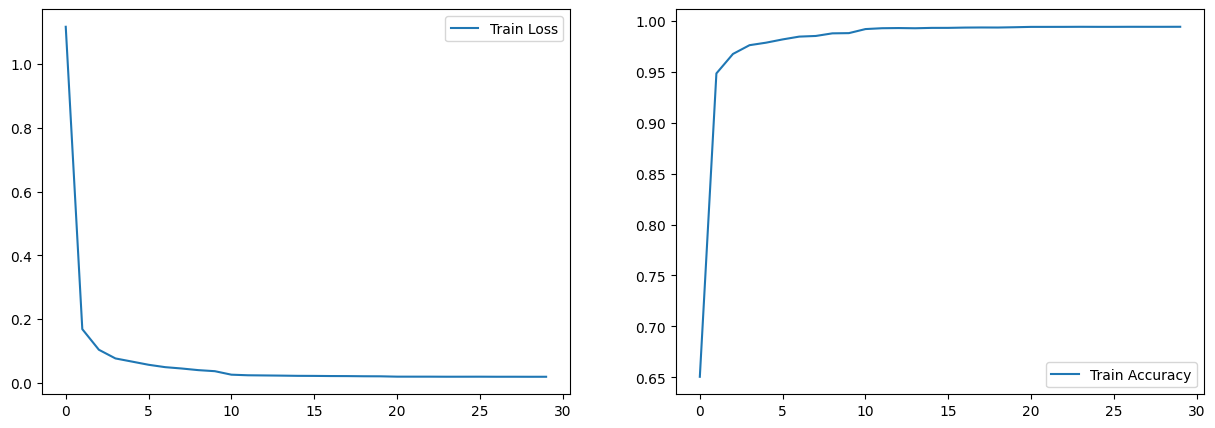

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(train_losses, train_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc)

## 在测试集上测试模型
通过模型运行测试数据集得到的结果，验证模型的泛化能力

In [11]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in tqdm(test_loader, 'test'):
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            pred = torch.argmax(output, dim=1)
            correct += (pred == targets).sum().item()
            total += targets.size(0)
    print(f"Test Acc: {correct / total:.3f}")

test(net, device, test_loader)

test: 100%|████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.68it/s]

Test Acc: 0.989


## 实例验证

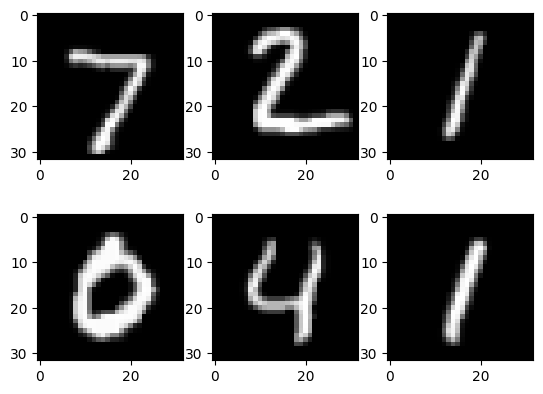

Predicted: "[7 2 1 0 4 1]", Actual: "[7 2 1 0 4 1]"


In [12]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

data = next(iter(test_loader))
images = data[0].cpu().numpy()
labels = data[1].cpu().numpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

net = net.to(device)
input = data[0].to(device)
with torch.no_grad():  # 不需要计算梯度，节省内存和计算资源  
    outputs = net(input) 

predicted = np.argmax(outputs.cpu().numpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')